In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import imageio as im
%matplotlib inline

#np.set_printoptions(threshold=np.nan)

class Pois_solver:
    def __init__(self, A, step, U, N, method, omega = 1, epsilon = .8): #A - размер сетки, N - число итераций, omega - параметр релаксации;
        #'J' - Якоби, 'G' - Гаусс, 'R' - релаксация
        self.A = A
        self.step = step
        self.N = N
        self.Nknots = int(A/step)
        self.U = U
        self.method = method
        self.omega = omega
        self.epsilon = epsilon
        self.density = np.empty(1)
        self.equip = np.empty(1)
    
    def set_density(self, filename_plus, filename_minus):    
        plus = im.imread(filename_plus)
        minus = im.imread(filename_minus)  
             
        self.density.resize((plus.shape[0], plus.shape[1]))
        self.density = (-plus.astype(int) + minus.astype(int))/255
        
    def set_equip(self, filename_plus, filename_minus): 
        plus = im.imread(filename_plus)
        minus = im.imread(filename_minus)  
             
        self.equip.resize((plus.shape[0], plus.shape[1]))
        self.equip = (-plus.astype(int) + minus.astype(int))/255
        
    def get_charge_and_draw(self):
        U__ = np.zeros(shape = (Nknots, Nknots))
        for i in range(0, self.Nknots -1):
                for j in range(0, self.Nknots - 1):
                     U__[i][j]= (self.U[i][j] - (self.U[i-1][j] + self.U[i+1][j] + self.U[i][j-1] + self.U[i][j+1])/4.)/np.pi
        self.U = U__
        self.show_plot()
        #self.show_contour()
     
    def trace(self):
        return np.abs(self.U.reshape(self.Nknots**2)[::self.Nknots + 1]).sum()
   
    def jacobi(self, n):
        tr = 0.

        for i in range(n):
            if (i % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
                           
            safe_first_string = self.U[0]
            safe_last_string = self.U[self.Nknots - 1]
            safe_first_column = self.U[:,0]
            safe_last_column = self.U[:,self.Nknots - 1]
            
            self.U = (np.roll(self.U, 1, 0) + np.roll(self.U, -1, 0) + np.roll(self.U, 1, 1) + np.roll(self.U, -1, 1))/4.
            if (self.density.size > 1):
                self.U += np.pi*self.density
            
            #восстанавливаем граничные значния (roll их нарушил)
            if(self.equip.size > 1):
                for i in range(self.Nknots):
                    for j in range(self.Nknots):
                        if self.equip[i][j] != 0:
                            self.U[i][j] = V*self.equip[i][j]
            else:
                self.U[self.Nknots - 1] = safe_last_string
                self.U[0] = safe_first_string 
                self.U[:,0] = safe_first_column
                self.U[:,self.Nknots - 1] = safe_last_column 
                       
            if (i % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print 'Breaked at i = ', i
                break
             
    def relax(self, n): #на основе jacobi
        tr = 0.
        U_new = np.zeros(shape = (self.Nknots, self.Nknots))
        for i in range(n):
            if (i % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
            
            safe_first_string = self.U[0]
            safe_last_string = self.U[self.Nknots - 1]
            safe_first_column = self.U[:,0]
            safe_last_column = self.U[:,self.Nknots - 1]
            
            U_new = (np.roll(self.U, 1, 0) + np.roll(self.U, -1, 0) + np.roll(self.U, 1, 1) + np.roll(self.U, -1, 1))/4.
            
            #восстанавливаем граничные значния (roll их нарушил)
            U_new[self.Nknots - 1] = safe_last_string
            U_new[0] = safe_first_string 
            U_new[:,0] = safe_first_column
            U_new[:,self.Nknots - 1] = safe_last_column 
            
            self.U = self.U + self.omega*(U_new - self.U)
            
            if (i % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print("Breaked at i = ", i)
                break
           
    def gauss(self, N):
        tr = 0.
        for n in range(N):
            if (n % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
            for i in range(1, self.Nknots - 1):
                for j in range(1, self.Nknots - 1):
                    self.U[i][j] = (self.U[i-1][j] + self.U[i+1][j] + self.U[i][j-1] + self.U[i][j+1])/4.
            if (n % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print 'Breaked at n = ', n
                break
    
    def evolution(self, n):
        if self.method == 'J':
            self.jacobi(n)
            
        if self.method == 'G':
            self.gauss(n)
            
        if self.method == 'R':
            self.relax(n)
        
    def show_plot(self):
        greed = np.empty((self.Nknots,self.Nknots), [('x',np.float64), ('y',np.float64)])
        greed['x'], greed['y'] = np.meshgrid(np.linspace(0, self.A, self.Nknots),\
                                                       np.linspace(0, self.A, self.Nknots))
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(greed['x'], greed['y'], self.U, rstride=5, cstride=5)
        
    def show_contour(self):
        greed = np.empty((self.Nknots,self.Nknots), [('x',np.float64), ('y',np.float64)])
        greed['x'], greed['y'] = np.meshgrid(np.linspace(0, self.A, self.Nknots),\
                                                       np.linspace(0, self.A, self.Nknots))
        
        fig = plt.figure(figsize=(10,8))
        CS = plt.contour(greed['x'], greed['y'], self.U, locator=plt.FixedLocator((-100, -80, -20, 0, 20, 80, 100)))
        plt.clabel(CS, inline=1, fontsize=10, colors='red')

        
    def run(self, snapshots):
        n = 0
        for n1 in snapshots:
            n = n1 - n
            self.evolution(n)
            self.show_plot()
            #self.show_contour()
        
        self.show_contour()

A = 1.
step = .01
N = 1000
V = 100
Nknots = int(A/step)

U = np.zeros(shape = (Nknots, Nknots))
snapshots = [1000]

C:\Anaconda2\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda2\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


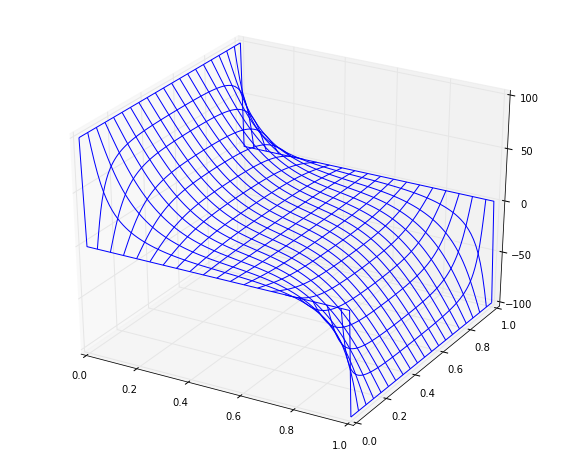

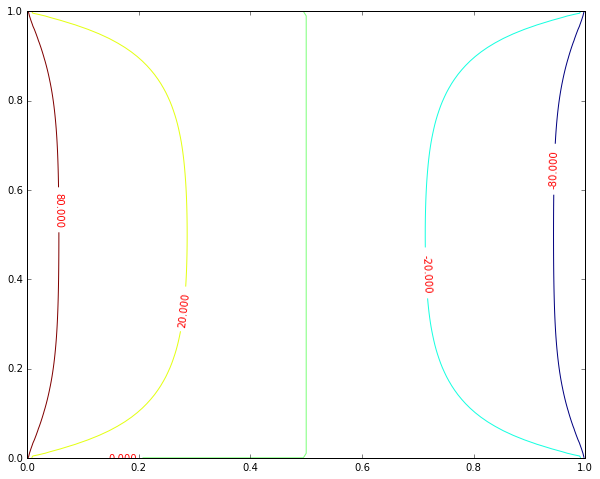

In [2]:
#простейшая модель конденсатора
U[:,0] = V
U[:,Nknots - 1] = -V
P0 = Pois_solver(A, step, U, N, 'J')
P0.run(snapshots)

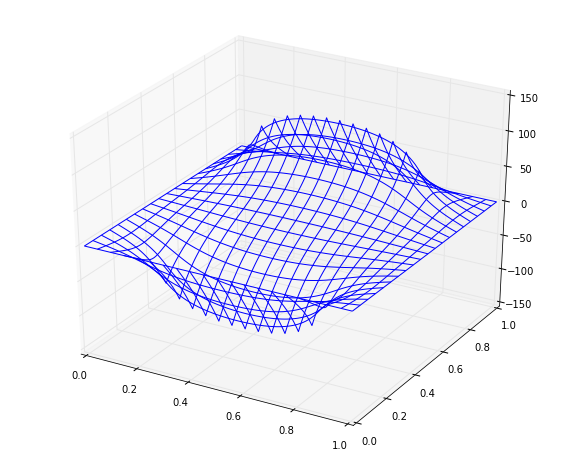

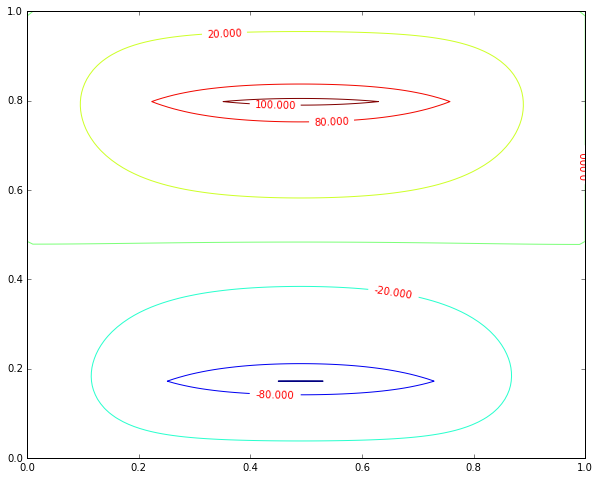

In [3]:
#конденсатор в виде тонких проводов
U = np.zeros(shape = (Nknots, Nknots))
P1 = Pois_solver(A, step, U, N, 'J')
P1.set_density('cond+.bmp', 'cond-.bmp')
P1.run(snapshots)

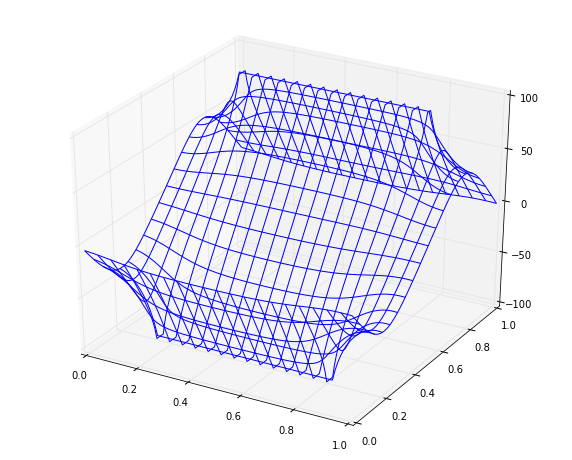

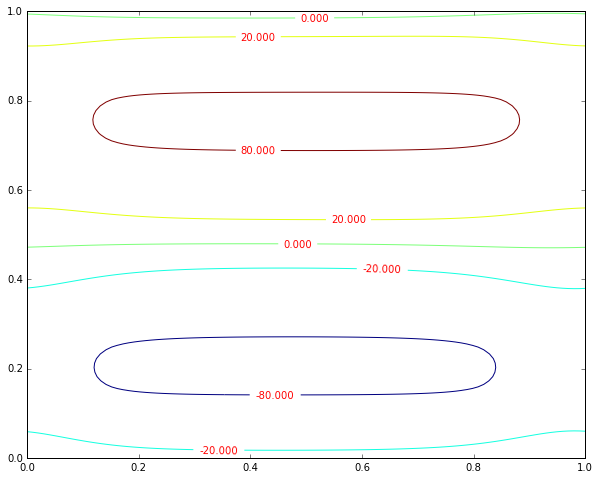

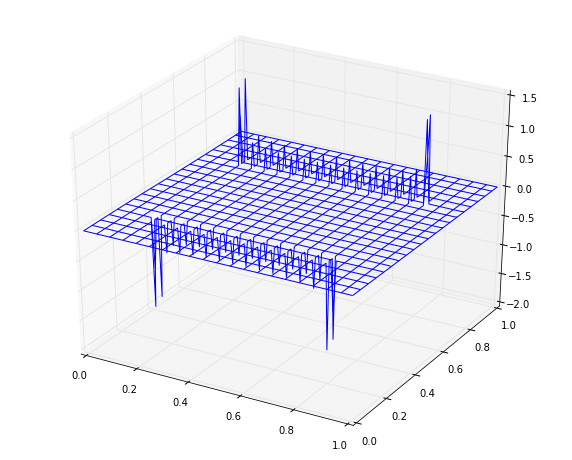

In [4]:
#конденсатор с эквипотенциальными пластинами
U = np.zeros(shape = (Nknots, Nknots))
P2 = Pois_solver(A, step, U, N, 'J')
P2.set_equip('cond_equip+.bmp', 'cond_equip-.bmp')#cond_equip.bmp
P2.run(snapshots)
P2.get_charge_and_draw()